In [126]:
import pandas as pd
import pycountry_convert as pc

# Import libraries
import numpy as np
import os
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import shap
import xgboost as xgb

In [127]:
# Define data folder
data_folder = "./DASS_data"
dataset = pd.read_csv("./DASS_data/data.csv", delimiter='\t', on_bad_lines='skip')

In [128]:
missing_values = dataset.isna().sum()
print(missing_values)

Q1A               0
Q1I               0
Q1E               0
Q2A               0
Q2I               0
              ...  
race              0
voted             0
married           0
familysize        0
major         11403
Length: 172, dtype: int64


In [129]:
# Drop multiple columns in-place
dataset.drop(["major"], axis=1, inplace=True)

In [130]:
# Define the questions contributing to each score
depression_questions = ['Q3A', 'Q5A', 'Q10A', 'Q13A', 'Q16A', 'Q17A', 'Q21A', 'Q24A', 'Q26A', 'Q31A', 'Q34A', 'Q37A', 'Q38A', 'Q42A']
anxiety_questions = ['Q2A', 'Q4A', 'Q7A', 'Q9A', 'Q15A', 'Q19A', 'Q20A', 'Q23A', 'Q25A', 'Q28A', 'Q30A', 'Q36A', 'Q40A', 'Q41A']
stress_questions = ['Q1A', 'Q6A', 'Q8A', 'Q11A', 'Q12A', 'Q14A', 'Q18A', 'Q22A', 'Q27A', 'Q29A', 'Q32A', 'Q33A', 'Q35A', 'Q39A']

# Identify columns that end with 'A'
columns_to_update = [col for col in dataset.columns if col.endswith('A')]
print(columns_to_update)

# Add 1 to each of these columns
for col in columns_to_update:
    dataset[col] = dataset[col] - 1

# Calculate the Depression, Anxiety, and Stress scores
dataset['Depression_Score'] = dataset[depression_questions].sum(axis=1)
dataset['Anxiety_Score'] = dataset[anxiety_questions].sum(axis=1)
dataset['Stress_Score'] = dataset[stress_questions].sum(axis=1)

['Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A', 'Q7A', 'Q8A', 'Q9A', 'Q10A', 'Q11A', 'Q12A', 'Q13A', 'Q14A', 'Q15A', 'Q16A', 'Q17A', 'Q18A', 'Q19A', 'Q20A', 'Q21A', 'Q22A', 'Q23A', 'Q24A', 'Q25A', 'Q26A', 'Q27A', 'Q28A', 'Q29A', 'Q30A', 'Q31A', 'Q32A', 'Q33A', 'Q34A', 'Q35A', 'Q36A', 'Q37A', 'Q38A', 'Q39A', 'Q40A', 'Q41A', 'Q42A']


In [131]:
# Define functions to categorize the scores
def categorize_depression(score):
    if score <= 9:
        return 0
    elif score <= 13:
        return 1
    elif score <= 20:
        return 2
    elif score <= 27:
        return 3
    else:
        return 4

def categorize_anxiety(score):
    if score <= 7:
        return 0
    elif score <= 9:
        return 1
    elif score <= 14:
        return 2
    elif score <= 19:
        return 3
    else:
        return 4

def categorize_stress(score):
    if score <= 14:
        return 0
    elif score <= 18:
        return 1
    elif score <= 25:
        return 2
    elif score <= 33:
        return 3
    else:
        return 4

In [132]:
# Apply the categorization functions
dataset['Depression_Level'] = dataset['Depression_Score'].apply(categorize_depression)
dataset['Anxiety_Level'] = dataset['Anxiety_Score'].apply(categorize_anxiety)
dataset['Stress_Level'] = dataset['Stress_Score'].apply(categorize_stress)

In [133]:
anxiety_data = dataset.drop(['Depression_Level', 'Stress_Level', 'Depression_Score', 'Stress_Score'], axis=1)

In [134]:
# Step 1: Identify columns ending with 'E'
time_columns = [col for col in anxiety_data.columns if col.endswith('E')]

# Step 3: Filter out rows with extreme values in any of the time columns
for col in time_columns:
    cutoff_value = 100000
    anxiety_data = anxiety_data[dataset[col] <= cutoff_value]

In [135]:
def encode_country(row):
    # Encode country into three major regions (east, west, other)
    country_code = row["country"]
    try:
        if country_code and country_code != "NONE":
            continent_name = pc.country_alpha2_to_continent_code(country_code)
            if continent_name == "AS":
                region_name = "east"
            elif continent_name in ["NA", "EU", "OC"]:
                region_name = "west"
            else:
                region_name = "other"
        else:
            region_name = ""
    except:
        region_name = ""
    return region_name
    
def encode_continent(row):
    # Encode country into three major regions (east, west, other)
    country_code = row["country"]
    try:
        if country_code and country_code != "NONE":
            continent_name = pc.country_alpha2_to_continent_code(country_code)
        else:
            continent_name = ""
    except:
        continent_name = ""
    return continent_name

def encode_age(row):
    # Encode age into groups
    age = int(row['age'])
    if age < 18:
        agegroup = 0
    elif age < 28:
        agegroup = 1
    elif age < 38:
        agegroup = 2
    elif age < 48:
        agegroup = 3
    elif age < 58:
        agegroup = 4
    elif age < 68:
        agegroup = 5
    else:
        agegroup = 6
    return agegroup

In [136]:
anxiety_data["agegroup"] = dataset.apply(lambda row: encode_age(row), axis=1)
anxiety_data["continent"] = dataset.apply(lambda row: encode_continent(row), axis=1)
anxiety_data["region"] = dataset.apply(lambda row: encode_country(row), axis=1)

In [137]:
# Filter data
anxiety_data.drop(anxiety_data[(anxiety_data['gender'] == 0) | (anxiety_data['gender'] == 3)].index, inplace=True)  # Male and females only
anxiety_data[anxiety_data['age'] >= 18]  # Adults only
anxiety_data = anxiety_data[anxiety_data['region'] != ""]  # Must have region
anxiety_data = anxiety_data.dropna()

# Remove data with countries that have strict data privacy laws (for public use only)
# Define the list of countries to exclude
countries_to_exclude = ["CH", "IN", "JA", "AU"]
# Filter the dataset to exclude the specified countries and continent
anxiety_data = anxiety_data[(anxiety_data['continent'] != "EU") & ~anxiety_data['country'].isin(countries_to_exclude)]

In [138]:
num_samples = anxiety_data.shape[0]
print("Number of samples:", num_samples)

Number of samples: 31629


In [139]:
# Data summary (after filtering)
print("\nAfter filtering:")
print(anxiety_data['gender'].value_counts())
print(anxiety_data['agegroup'].value_counts())
print(anxiety_data['age'].mean(), anxiety_data['age'].std())
print(anxiety_data['continent'].value_counts())
print(anxiety_data['region'].value_counts())
print(anxiety_data['Anxiety_Score'].value_counts())


After filtering:
2    25094
1     6535
Name: gender, dtype: int64
1    20888
0     5434
2     3393
3     1043
4      592
5      216
6       63
Name: agegroup, dtype: int64
23.420689873217615 23.621835097052116
AS    22357
NA     8546
SA      306
AF      216
OC      204
Name: continent, dtype: int64
east     22357
west      8750
other      522
Name: region, dtype: int64
10    1166
13    1150
7     1134
6     1109
12    1106
8     1100
9     1097
14    1083
11    1078
16    1046
5     1018
4     1016
3      999
15     984
17     963
18     944
22     922
19     908
20     901
21     887
2      856
23     813
24     796
25     745
1      739
0      671
26     660
28     628
27     624
29     563
30     529
31     468
32     465
33     378
34     356
35     320
36     294
37     262
38     214
39     185
42     184
40     149
41     119
Name: Anxiety_Score, dtype: int64


In [140]:
# Define the data based on your provided summary
table_data = {
    'Continent': ['Asia', 'Europe', 'North America', 'Other'],
    'Mean Age (years)': [23.6, 28.5, 29.9, 28.7],
    'Standard deviation Age (years)': [27.0, 11.3, 12.9, 11.6],
    'Males': [3896, 955, 2016, 350],
    'Females': [18246, 1543, 3990, 719]
}

# Create DataFrame
df = pd.DataFrame(table_data)

# Display the DataFrame
print(df)

# Convert the DataFrame to LaTeX format
latex_table = df.to_latex(index=False, caption="Demographic Information by Continent")

# Print the LaTeX table
print(latex_table)

       Continent  Mean Age (years)  Standard deviation Age (years)  Males  \
0           Asia              23.6                            27.0   3896   
1         Europe              28.5                            11.3    955   
2  North America              29.9                            12.9   2016   
3          Other              28.7                            11.6    350   

   Females  
0    18246  
1     1543  
2     3990  
3      719  
\begin{table}
\centering
\caption{Demographic Information by Continent}
\begin{tabular}{lrrrr}
\toprule
    Continent &  Mean Age (years) &  Standard deviation Age (years) &  Males &  Females \\
\midrule
         Asia &              23.6 &                            27.0 &   3896 &    18246 \\
       Europe &              28.5 &                            11.3 &    955 &     1543 \\
North America &              29.9 &                            12.9 &   2016 &     3990 \\
        Other &              28.7 &                            11.6 &   

In [141]:
for col in anxiety_data.columns:
    if "TIPI" in col or "VCL" in col:
        anxiety_data = anxiety_data.drop([col], axis=1)
    elif col[0] == "Q" and (col[-1] == "E" or col[-1] == "I"):
        anxiety_data = anxiety_data.drop([col], axis=1)

In [142]:
# Define data folder
seed = 100
data_folder = "./DASS_data"

features_dataframe = anxiety_data.drop(['Anxiety_Level', 'Anxiety_Score'], axis=1)
features_dataframe.to_csv(os.path.join(data_folder, "original_features.csv"), index=None)

In [143]:
anxiety_score_counts = anxiety_data['Anxiety_Level'].value_counts()
anxiety_score_proportions = anxiety_score_counts / len(anxiety_data)
anxiety_score_counts, anxiety_score_proportions

(4    11462
 0     7542
 2     5583
 3     4845
 1     2197
 Name: Anxiety_Level, dtype: int64,
 4    0.362389
 0    0.238452
 2    0.176515
 3    0.153182
 1    0.069462
 Name: Anxiety_Level, dtype: float64)

In [144]:
def preprocess(dataframe):
    
    anxiety_level_0 = dataframe[dataframe['Anxiety_Level'] == 0]
    anxiety_level_1 = dataframe[dataframe['Anxiety_Level'] == 1]
    anxiety_level_2 = dataframe[dataframe['Anxiety_Level'] == 2]
    anxiety_level_3 = dataframe[dataframe['Anxiety_Level'] == 3]
    anxiety_level_4 = dataframe[dataframe['Anxiety_Level'] == 4]
    
    # Upsample the minority classes
    anxiety_level_0_upsampled = resample(anxiety_level_0, replace=True, n_samples=len(anxiety_level_4.index), random_state=seed)
    anxiety_level_1_upsampled = resample(anxiety_level_1, replace=True, n_samples=len(anxiety_level_4.index), random_state=seed)
    anxiety_level_2_upsampled = resample(anxiety_level_2, replace=True, n_samples=len(anxiety_level_4.index), random_state=seed)
    anxiety_level_3_upsampled = resample(anxiety_level_3, replace=True, n_samples=len(anxiety_level_4.index), random_state=seed)
    
    anxiety_data_upsampled = pd.concat([anxiety_level_0_upsampled, anxiety_level_1_upsampled, anxiety_level_2_upsampled, anxiety_level_3_upsampled, anxiety_level_4])
    anxiety_data = anxiety_data_upsampled.reset_index(drop=True)
    
    labels_dataframe = anxiety_data[['Anxiety_Level']].copy()
    features_dataframe = anxiety_data.drop(['Anxiety_Level', 'Anxiety_Score'], axis=1)
    features_dataframe.to_csv(os.path.join(data_folder, "original_features.csv"), index=None)
    
    # z-score normalization
    def z_score_norm(row, col, mean, stdev):
        z_score = (float(row[col]) - mean) / stdev
        return float(z_score)
    
    # One-hot encode gender and region
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder()
    
    # Label encode the target
    label_encoder = LabelEncoder()
    dataframe['Anxiety_Level'] = label_encoder.fit_transform(dataframe['Anxiety_Level'])
    
    # Gender
    gender = label_encoder.fit_transform(features_dataframe["gender"])
    gender = pd.DataFrame(gender)
    gender = pd.DataFrame(onehot_encoder.fit_transform(gender).toarray())
    gender.columns = ["gender_m", "gender_f"]
    
    # Region
    region = label_encoder.fit_transform(features_dataframe["region"])
    region = pd.DataFrame(region)
    region = pd.DataFrame(onehot_encoder.fit_transform(region).toarray())
    region.columns = ["region_other", "region_east", "region_west"]
    
    # Combine and remove original columns
    features_dataframe = features_dataframe.drop(["gender", "country", "region", "agegroup", "continent"], axis=1)
    features_dataframe = pd.concat([features_dataframe, gender, region], axis=1)
    
    # One-hot encode question answers
    for col in features_dataframe.columns:
        if col[0] == "Q" and col[-1] == "A":
            temp = label_encoder.fit_transform(features_dataframe[col])
            temp = pd.DataFrame(temp)
            temp = pd.DataFrame(onehot_encoder.fit_transform(temp).toarray())

            col_names = []
            for c in temp.columns:
                col_names.append("{0}_{1}".format(col, c))
            temp.columns = col_names

            features_dataframe = features_dataframe.drop([col], axis=1)
            features_dataframe = pd.concat([features_dataframe, temp], axis=1)
    
    # Normalize numerical columns (Use z-score)
    mean = features_dataframe["age"].mean()
    stdev = features_dataframe["age"].std()
    features_dataframe["age_norm"] = features_dataframe.apply(
                    lambda row: z_score_norm(row, "age", mean, stdev), axis=1)
    features_dataframe = features_dataframe.drop(["age"], axis=1)
    

    return features_dataframe, labels_dataframe

In [145]:
# Split into features and labels, save as CSV
features_df, labels_df = preprocess(anxiety_data)
# One hot coded. Save as CSV
features_df.to_csv(os.path.join(data_folder, "features.csv"), index=None)
labels_df.to_csv(os.path.join(data_folder, "labels.csv"), index=None)

In [146]:
anxiety_score_counts = labels_df['Anxiety_Level'].value_counts()
anxiety_score_proportions = anxiety_score_counts / len(labels_df)
anxiety_score_counts, anxiety_score_proportions

(0    11462
 1    11462
 2    11462
 3    11462
 4    11462
 Name: Anxiety_Level, dtype: int64,
 0    0.2
 1    0.2
 2    0.2
 3    0.2
 4    0.2
 Name: Anxiety_Level, dtype: float64)

In [147]:
from mrmr import mrmr_classif


train_feats = pd.read_csv(os.path.join(data_folder, "features.csv"))
train_feats = train_feats.drop(["age_norm", "gender_m", "gender_f", "region_other", "region_east", "region_west"], axis=1)  # Comment this line to include demographics
labels = pd.read_csv(os.path.join(data_folder, "labels.csv"))

labels = labels["Anxiety_Level"]

selected_features = mrmr_classif(X=train_feats, y=labels, K=10)
print(selected_features)

KeyboardInterrupt: 

In [ ]:
# Not one-hot encoded dataset
train_feats = anxiety_data # Using sample dataset. Change the file name accordingly if using another dataset.
train_feats = train_feats.drop(["country","gender","age","agegroup","continent","region","Anxiety_Score", "Anxiety_Level"], axis=1)

labels = anxiety_data["Anxiety_Level"]

# print(MRMR(train_feats.to_numpy(), labels.to_numpy().ravel(), show_top)) # The customized function approach
selected_features = mrmr_classif(X=train_feats, y=labels, K=10) # The mrmr library approach
print(selected_features)

100%|██████████| 10/10 [00:01<00:00,  6.38it/s]

['Q28A', 'Q20A', 'Q40A', 'Q7A', 'Q36A', 'Q9A', 'Q4A', 'Q41A', 'Q30A', 'Q25A']


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Load the dataset
X = pd.read_csv(os.path.join(data_folder, "original_features.csv"))
y = pd.read_csv(os.path.join(data_folder, "labels.csv"))
for column in X.columns:
    if "A" not in column:
        X.drop([column], axis=1, inplace=True)

print(X.shape, y.shape)


(57310, 42) (57310, 1)


In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(45848, 42) (11462, 42) (45848, 1) (11462, 1)


In [ ]:
model = RandomForestClassifier(n_estimators=100,random_state=1200)
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=1200)

In [ ]:
# Create a SHAP explainer object
explainer = shap.TreeExplainer(model)



In [ ]:
# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)
print(shap_values.shape)

(45848, 42, 5)


In [ ]:
shap_obj = explainer(X_train)

In [ ]:
# Aggregate SHAP values across classes and samples
shap_values_abs = np.abs(shap_values).sum(axis=2).mean(axis=0)
print(shap_values_abs.shape)
# Ensure the resulting array is 1-dimensional
shap_values_abs = shap_values_abs.flatten()
print(shap_values_abs.shape)

(42,)
(42,)


In [ ]:
feature_names = [f"Q{i}A" for i in range(1, 43)]
# Assuming shap_values and feature_names are already defined
abs_shap_values = np.abs(shap_values).sum(axis=(0, 2))
# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': abs_shap_values})

print(feature_importance_df)
print(type(feature_importance_df))


   feature   importance
0      Q1A  1250.325967
1      Q2A  3854.401470
2      Q3A   456.574936
3      Q4A  6136.385015
4      Q5A   487.003125
5      Q6A   613.457387
6      Q7A  7218.079453
7      Q8A   930.949496
8      Q9A  5739.837215
9     Q10A   510.126603
10    Q11A   834.631792
11    Q12A  2192.956648
12    Q13A   714.704552
13    Q14A   603.436080
14    Q15A  3557.987580
15    Q16A   558.713982
16    Q17A   914.411125
17    Q18A   556.415738
18    Q19A  4272.656590
19    Q20A  7045.723733
20    Q21A   644.863426
21    Q22A   707.762499
22    Q23A  2705.023629
23    Q24A   524.215813
24    Q25A  5568.601538
25    Q26A   583.141893
26    Q27A   594.565074
27    Q28A  7965.206378
28    Q29A   875.293954
29    Q30A  5267.050812
30    Q31A   464.968455
31    Q32A   660.064808
32    Q33A  2115.823412
33    Q34A   817.389309
34    Q35A   530.811453
35    Q36A  7712.739053
36    Q37A   533.273005
37    Q38A   576.136388
38    Q39A   554.014598
39    Q40A  9182.809838
40    Q41A  6061

In [149]:
top_10_features_df = feature_importance_df.sort_values(by='importance', ascending=False).head(10)
print(top_10_features_df)
top_10_features = top_10_features_df['feature'].values
print(top_10_features)
top_10_indices = top_10_features_df.index.values
print(top_10_indices)
top_10_shap_values = shap_values[:, top_10_indices, :]
print(top_10_shap_values.shape)

   feature   importance
39    Q40A  9182.809838
27    Q28A  7965.206378
35    Q36A  7712.739053
6      Q7A  7218.079453
19    Q20A  7045.723733
3      Q4A  6136.385015
40    Q41A  6061.565379
8      Q9A  5739.837215
24    Q25A  5568.601538
29    Q30A  5267.050812
['Q40A' 'Q28A' 'Q36A' 'Q7A' 'Q20A' 'Q4A' 'Q41A' 'Q9A' 'Q25A' 'Q30A']
[39 27 35  6 19  3 40  8 24 29]
(45848, 10, 5)


In [150]:
X_train_selected = X_train.loc[:, top_10_features]

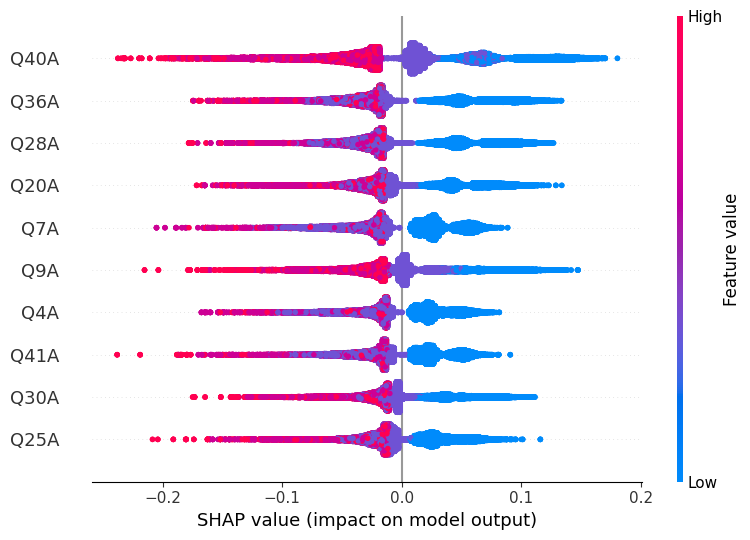

In [170]:
# Generate the plot
shap.summary_plot(shap_values=np.take(shap_obj.values, 0, axis=-1),
                  features=X_train,
                  feature_names=X_train.columns,
                  max_display=10)


In [171]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report

In [172]:
# Load the data
features = pd.read_csv('DASS_data/original_features.csv')  # Update with the correct file path
labels = pd.read_csv('DASS_data/labels.csv')      # Update with the correct file path

In [173]:
# Specify the desired features
selected_features = ['Q40A', 'Q28A', 'Q20A', 'Q36A', 'Q9A', 'Q9A', 'Q25A', 'Q30A', 'Q7A', 'Q4A']

# Extract the selected features
X = features[selected_features]
y = labels['Anxiety_Level']  # Ensure 'label' column contains the multi-class labels (0-4)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [174]:
# Define the neural network
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  # 5 output units for the 5 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.4853 - loss: 1.1684 - val_accuracy: 0.6781 - val_loss: 0.6936
Epoch 2/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.6621 - loss: 0.7548 - val_accuracy: 0.7055 - val_loss: 0.6462
Epoch 3/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.6814 - loss: 0.7167 - val_accuracy: 0.7261 - val_loss: 0.6167
Epoch 4/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.6947 - loss: 0.6920 - val_accuracy: 0.7305 - val_loss: 0.6062
Epoch 5/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - accuracy: 0.6996 - loss: 0.6804 - val_accuracy: 0.7292 - val_loss: 0.6053
Epoch 6/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - accuracy: 0.7052 - loss: 0.6672 - val_accuracy: 0.7304 - val_loss: 0.6019
Epoch 7/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.7120 - loss: 0.6569 - val_accuracy: 0.7389 - val_loss: 0.5933
Epoch 8/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - ac

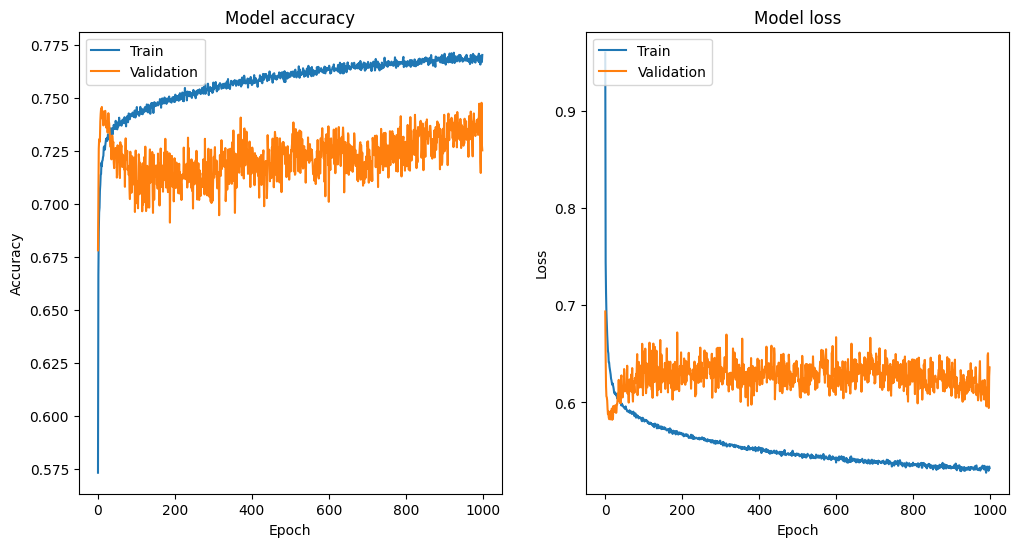

In [175]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [176]:
import torch
# Splitting data to train val test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=5)
# Converting data to Torch tensor
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.long)
val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.long)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [177]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'val_input': val_input,
    'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}

In [178]:
from kan import KAN

kan_model = KAN([10, 7, 5], grid=10, k=3)

In [179]:
# Fuctions for getting accuracy scores while training
def train_acc():
    preds = torch.argmax(kan_model(dataset['train_input']), dim=1)
    return torch.mean((preds == dataset['train_label']).float())

def test_acc():
    preds = torch.argmax(kan_model(dataset['test_input']), dim=1)
    return torch.mean((preds == dataset['test_label']).float())

In [180]:
# KAN model training
results = kan_model.train({'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
                      metrics=(train_acc, test_acc),
                      opt="LBFGS", steps=100, loss_fn=torch.nn.CrossEntropyLoss())

train loss: 7.38e-01 | test loss: 7.48e-01 | reg: 3.92e+01 : 100%|█| 100/100 [55:10<00:00, 33.10s/it


In [181]:
# Predictions of train val and test datasets
test_preds = torch.argmax(kan_model.forward(test_input).detach(),dim=1)
test_labels = test_label

train_preds = torch.argmax(kan_model.forward(train_input).detach(),dim=1)
train_labels = train_label

val_preds = torch.argmax(kan_model.forward(val_input).detach(),dim=1)
val_labels = val_label


# Evaluate metrics

print("Train ACC:", accuracy_score(train_labels.numpy(), train_preds.numpy()))

print("Val ACC:", accuracy_score(val_labels.numpy(), val_preds.numpy()))

print("Test ACC:", accuracy_score(test_labels.numpy(), test_preds.numpy()))

Train ACC: 0.7577585562230476
Val ACC: 0.7512796649604467
Test ACC: 0.7453762940560661


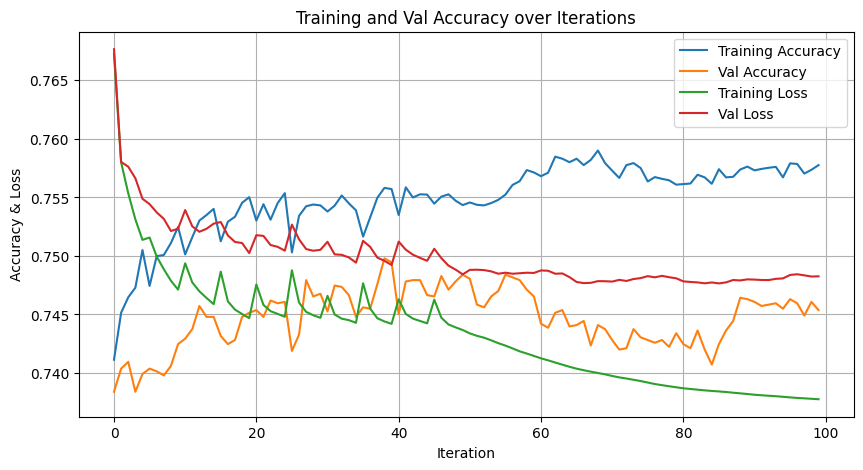

In [182]:
import matplotlib.pyplot as plt
# Learning curve based on ACC and LOSS
plt.figure(figsize=(10, 5))
plt.plot(results["train_acc"], label='Training Accuracy')
plt.plot(results["test_acc"], label='Val Accuracy')
plt.plot(results["train_loss"], label='Training Loss')
plt.plot(results["test_loss"], label='Val Loss')
plt.title('Training and Val Accuracy over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy & Loss')
plt.legend()
plt.grid(True)
plt.show()

In [183]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)

In [184]:
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [185]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
y_pred = clf.predict(X_test)
print("Accuracy of KNN Regression:",accuracy_score(y_test, y_pred))


Accuracy of KNN Regression: 0.7812027451436547


In [186]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [187]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])

In [188]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)
y_test = encoder.transform(y_train)

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test)
Y_pred_label = list(encoder.inverse_transform(Y_pred))

Best score for training data: 0.7441733319299237 

Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.001 



In [189]:
from sklearn.svm import SVC

# Create the SVM model with the best parameters
svm_model = SVC(C=100, kernel='rbf', gamma=0.001)

# Fit the model to the training data
svm_model.fit(X_train, y_train)

SVC(C=100, gamma=0.001)

In [217]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, cohen_kappa_score, roc_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import os
import random
import pickle
import matplotlib.pyplot as plt

# Define confidence interval function
def confidence_interval(data):
    return np.percentile(data, 97.5), np.percentile(data, 2.5)

# Define the Keras MLP model function
def create_mlp(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(5, activation='softmax')  # 5 output units for the 5 classes
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

import torch
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class KANWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dims, grid, k, steps=100):
        self.input_dims = input_dims
        self.grid = grid
        self.k = k
        self.steps = steps
        self.kan_model = KAN(input_dims, grid=grid, k=k)
        
    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        
        train_input = torch.tensor(X, dtype=torch.float32)
        train_label = torch.tensor(y, dtype=torch.long)
        val_input = train_input  # Assuming using same data for simplicity, modify as needed
        val_label = train_label  # Assuming using same data for simplicity, modify as needed
        
        # Functions for getting accuracy scores while training
        def train_acc():
            preds = torch.argmax(self.kan_model(train_input), dim=1)
            return torch.mean((preds == train_label).float())

        def test_acc():
            preds = torch.argmax(self.kan_model(val_input), dim=1)
            return torch.mean((preds == val_label).float())

        # KAN model training
        self.kan_model.train({'train_input': train_input, 'train_label': train_label, 
                              'test_input': val_input, 'test_label': val_label},
                             metrics=(train_acc, test_acc),
                             opt="LBFGS", steps=self.steps, loss_fn=torch.nn.CrossEntropyLoss())
        
        return self
    
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        test_input = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            preds = torch.argmax(self.kan_model(test_input), dim=1)
        return preds.numpy()
    
    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        test_input = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            output = self.kan_model(test_input)
        return torch.nn.functional.softmax(output, dim=1).numpy()
    
    def score(self, X, y):
        preds = self.predict(X)
        return accuracy_score(y, preds)



question_numbers = [1, 2, 3, 4, 5, 6, 7, 8]         # Numbers of questions from DASS to run through
target = "Anxiety_Level"
models_to_train = 1        # Number of models for each number of questions from DASS
models_per_question = 1    # Number of ensembles per model
test_split = 0.1
model_type = "lr"     # Specify model type (xgb, rf, lr, svm, mlp)
seed = 42
random.seed(seed)


ACCS = []
AUCS = []
PRES = []
RECS = []
F1S = []
AUC_STDEV = []
F1_STDEV = []
AUC_95CI_U = []
AUC_95CI_D = []
F1_95CI_U = []
F1_95CI_D = []
KAPPAS=[]
KAPPA_STDEV=[]
KAPPA_95CI_U=[]
KAPPA_95CI_D=[]


features_df = pd.read_csv(os.path.join(data_folder, "features.csv"))
labels_df = pd.read_csv(os.path.join(data_folder, "labels.csv"))
questions = [40, 28, 20, 36, 9, 41, 25, 30, 7, 4]

In [218]:
def train_acc():
                preds = torch.argmax(kan_model(dataset['train_input']), dim=1)
                return torch.mean((preds == dataset['train_label']).float())

def test_acc():
    preds = torch.argmax(kan_model(dataset['test_input']), dim=1)
    return torch.mean((preds == dataset['test_label']).float())

In [220]:
# For different numbers of questions from DASS-42
for num_questions in range(1, 11):
    
    models_info = {}

    accs = []
    aucs = []
    pres = []
    recs = []
    f1s = []
    kappas = []  # List to store mean Cohen's Kappa scores
    auc_stdev = []
    f1_stdev = []
    kappa_stdev = []  # List to store Cohen's Kappa standard deviations
    auc_95ci_u = []
    auc_95ci_d = []
    f1_95ci_u = []
    f1_95ci_d = []
    kappa_95ci_u = []  # List to store upper confidence intervals of Cohen's Kappa
    kappa_95ci_d = []  # List to store lower confidence intervals of Cohen's Kappa
    lst_comb = []

    model_num = 0
    for a in range(10):  # Adjust the number of models to train as needed
        model = {}

        print("Training model", a)
        cols = ["gender_m", "gender_f", "region_other", 
                "region_east", "region_west", "age_norm"]

        if num_questions == 1:
            if a >= len(questions):
                break
            question_nums = [questions[a]]
        else:
            question_nums = random.sample(questions, num_questions)
            question_nums.sort()
            while question_nums in lst_comb:
                question_nums = random.sample(questions, num_questions)
            lst_comb.append(question_nums)

        for q in question_nums:
            for j in range(4):
                col_name = f"Q{q}A_{j}"  # Adjust column name formatting as necessary
                if col_name in features_df.columns:
                    cols.append(col_name)
                else:
                    print(f"Warning: Column {col_name} not found in features_df. Skipping this column.")

        features = features_df[cols]

        labels = labels_df.copy()

        np.random.seed(seed)
        shufId = np.random.permutation(len(labels))
        index = int(test_split * len(labels))

        df_prist = features.iloc[shufId[0:index]]
        df_trainvalid = features.iloc[shufId[index:]]

        gt_prist = labels.iloc[shufId[0:index]]
        gt_trainvalid = labels.iloc[shufId[index:]]

        df_prist.to_csv(os.path.join(data_folder, "prist_features.csv"), index=False)
        gt_prist.to_csv(os.path.join(data_folder, "prist_labels.csv"), index=False)

        accs1 = []
        aucs1 = []
        pres1 = []
        recs1 = []
        f1s1 = []
        kappas1 = []  # List to store Cohen's Kappa scores for this iteration
        ensemble_models = []

        for b in tqdm(range(1), desc="Inner Loop Progress", leave=False):  # Adjust the number of iterations as needed
            if b % 10 == 0:
                print("Training iteration", b)

            np.random.seed(b)
            shufId = np.random.permutation(len(gt_trainvalid))
            index = int((1/9) * len(gt_trainvalid))

            df_valid = df_trainvalid.iloc[shufId[0:index]]
            df_train = df_trainvalid.iloc[shufId[index:]]

            gt_valid = gt_trainvalid.iloc[shufId[0:index]]
            gt_train = gt_trainvalid.iloc[shufId[index:]]

            df_valid = df_valid.reset_index(drop=True)
            df_train = df_train.reset_index(drop=True)

            gt_valid = gt_valid.reset_index(drop=True)
            gt_train = gt_train.reset_index(drop=True)
            # Convert DataFrame and Series objects to NumPy arrays
            train_input_np = df_train.to_numpy()
            train_label_np = gt_train.to_numpy().squeeze()
            val_input_np = df_valid.to_numpy()
            val_label_np = gt_valid.to_numpy().squeeze()
            test_input_np = df_prist.to_numpy()
            test_label_np = gt_prist.to_numpy().squeeze()

            # Convert NumPy arrays to PyTorch tensors
            train_input = torch.tensor(train_input_np, dtype=torch.float32)
            train_label = torch.tensor(train_label_np, dtype=torch.long)
            val_input = torch.tensor(val_input_np, dtype=torch.float32)
            val_label = torch.tensor(val_label_np, dtype=torch.long)
            test_input = torch.tensor(test_input_np, dtype=torch.float32)
            test_label = torch.tensor(test_label_np, dtype=torch.long)

            # Create a dictionary to store these tensors
            dataset = {
                'train_input': train_input,
                'train_label': train_label,
                'val_input': val_input,
                'val_label': val_label,
                'test_input': test_input,
                'test_label': test_label
            }
            print("NUMBER OF QUESTIONS IS: ", num_questions)
            kan_model = KAN([train_input.shape[1], 7, 5], grid=10, k=3)
            print(train_input.shape[1])
            
            kan_model.train(dataset,
                      metrics=(train_acc, test_acc),
                      opt="LBFGS", steps=100, loss_fn=torch.nn.CrossEntropyLoss())

            # # Define the individual models
            # knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
            # knn.fit(df_train, gt_train.values.ravel())
            # svm_model = SVC(C=100, kernel='rbf', gamma=0.001)
            # svm_model.fit(df_train, gt_train.values.ravel())

            # xgbpprist = svm_model.predict(df_prist)
            # xgbpprist = pd.DataFrame(xgbpprist)
            test_preds = torch.argmax(kan_model.forward(test_input).detach(),dim=1)
            # Store the evaluation results
            acc_score = accuracy_score(gt_prist, test_preds)
            auc_score = roc_auc_score(label_binarize(gt_prist, classes=[0, 1, 2, 3, 4]),
                                      label_binarize(test_preds, classes=[0, 1, 2, 3, 4]), multi_class='ovr')
            fpr, tpr, thresh = roc_curve(label_binarize(gt_prist, classes=[0, 1, 2, 3, 4]).ravel(),
                                         label_binarize(test_preds, classes=[0, 1, 2, 3, 4]).ravel())
            plt.plot(fpr, tpr)

            # Evaluation
            target_names = ['class1', 'class2', 'class3', 'class4', 'class5']  # Adjust class names as needed
            cr = classification_report(gt_prist, test_preds, target_names=target_names, output_dict=True)
            precision = cr["weighted avg"]["precision"]
            recall = cr["weighted avg"]["recall"]
            f1score = cr["weighted avg"]["f1-score"]

            kappa_score = cohen_kappa_score(gt_prist, test_preds)  # Calculate Cohen's Kappa score  

            accs1.append(acc_score)
            aucs1.append(auc_score)
            pres1.append(precision)
            recs1.append(recall)
            f1s1.append(f1score)
            kappas1.append(kappa_score)  # Append Cohen's Kappa score
            ensemble_models.append(kan_model)

        mean_acc1 = np.mean(accs1)
        mean_auc1 = np.mean(aucs1)
        stdev_auc1 = np.std(aucs1)
        ci_auc1_u, ci_auc1_d = confidence_interval(aucs1)
        mean_pre1 = np.mean(pres1)
        mean_rec1 = np.mean(recs1)
        mean_f11 = np.mean(f1s1)
        stdev_f11 = np.std(f1s1)
        ci_f11_u, ci_f11_d = confidence_interval(f1s1)
        mean_kappa1 = np.mean(kappas1)  # Mean Cohen's Kappa
        stdev_kappa1 = np.std(kappas1)  # Standard deviation of Cohen's Kappa
        ci_kappa1_u, ci_kappa1_d = confidence_interval(kappas1)  # Confidence interval for Cohen's Kappa

        accs.append(mean_acc1)
        aucs.append(mean_auc1)
        auc_stdev.append(stdev_auc1)
        auc_95ci_u.append(ci_auc1_u)
        auc_95ci_d.append(ci_auc1_d)
        pres.append(mean_pre1)
        recs.append(mean_rec1)
        f1s.append(mean_f11)
        f1_stdev.append(stdev_f11)
        f1_95ci_u.append(ci_f11_u)
        f1_95ci_d.append(ci_f11_d)
        kappas.append(mean_kappa1)  # Append mean Cohen's Kappa
        kappa_stdev.append(stdev_kappa1)  # Append Cohen's Kappa standard deviation
        kappa_95ci_u.append(ci_kappa1_u)  # Append upper confidence interval for Cohen's Kappa
        kappa_95ci_d.append(ci_kappa1_d)  # Append lower confidence interval for Cohen's Kappa

        model["questions"] = question_nums
        # model["knn_params"] = kan_model.get_params()
        model["acc_score"] = acc_score
        model["auc_score"] = mean_auc1
        model["f1_score"] = mean_f11
        model["kappa_score"] = mean_kappa1  # Store mean Cohen's Kappa

        models_info[model_num] = model
        model_num += 1

    mean_acc = np.mean(accs)
    mean_auc = np.mean(aucs)
    stdev_auc = np.mean(auc_stdev)
    ci_auc_u = np.mean(auc_95ci_u)
    ci_auc_d = np.mean(auc_95ci_d)
    mean_pre = np.mean(pres)
    mean_rec = np.mean(recs)
    mean_f1  = np.mean(f1s)
    stdev_f1 = np.mean(f1_stdev)
    ci_f1_u = np.mean(f1_95ci_u)
    ci_f1_d = np.mean(f1_95ci_d)
    mean_kappa = np.mean(kappas)  # Mean Cohen's Kappa
    stdev_kappa = np.mean(kappa_stdev)  # Standard deviation of Cohen's Kappa
    ci_kappa_u = np.mean(kappa_95ci_u)  # Upper confidence interval for Cohen's Kappa
    ci_kappa_d = np.mean(kappa_95ci_d)  # Lower confidence interval for Cohen's Kappa

    percentile_list = pd.DataFrame(
    {
        'accuracy': accs,
        'auc_roc': aucs,
        'auc_stdev': auc_stdev,
        'auc_95ci_u': auc_95ci_u,
        'auc_95ci_d': auc_95ci_d,
        'precision': pres,
        'recall': recs,
        'f1_score': f1s,
        'f1_stdev': f1_stdev,
        'f1_95ci_u': f1_95ci_u,
        'f1_95ci_d': f1_95ci_d,
        'kappa_score': kappas,  # Add Cohen's Kappa scores
        'kappa_stdev': kappa_stdev,  # Add Cohen's Kappa standard deviation
        'kappa_95ci_u': kappa_95ci_u,  # Add upper confidence interval for Cohen's Kappa
        'kappa_95ci_d': kappa_95ci_d,  # Add lower confidence interval for Cohen's Kappa
    })
    percentile_list.to_csv('./data/results_{}.csv'.format(model_type), mode='a', header=True)

    print("\nNumber of questions:", num_questions)
    print("Mean AUC      :", mean_auc)
    print("Stdev AUC     :", stdev_auc)
    print("95th CI AUC   :", ci_auc_u, ci_auc_d)
    print("Mean F1-Score :", mean_f1)
    print("Stdev F1      :", stdev_f1)
    print("95th CI F1    :", ci_f1_u, ci_f1_d)
    print("Mean Cohen's Kappa:", mean_kappa)  # Print mean Cohen's Kappa
    print("Stdev Kappa   :", stdev_kappa)  # Print standard deviation of Cohen's Kappa
    print("95th CI Kappa :", ci_kappa_u, ci_kappa_d)  # Print confidence interval for Cohen's Kappa

    ACCS.append(mean_acc)
    AUCS.append(mean_auc)
    AUC_STDEV.append(stdev_auc)
    AUC_95CI_U.append(ci_auc_u)
    AUC_95CI_D.append(ci_auc_d)
    PRES.append(mean_pre)
    RECS.append(mean_rec)
    F1S.append(mean_f1)
    F1_STDEV.append(stdev_f1)
    F1_95CI_U.append(ci_f1_u)
    F1_95CI_D.append(ci_f1_d)
    KAPPAS.append(mean_kappa)  # Append mean Cohen's Kappa
    KAPPA_STDEV.append(stdev_kappa)  # Append Cohen's Kappa standard deviation
    KAPPA_95CI_U.append(ci_kappa_u)  # Append upper confidence interval for Cohen's Kappa
    KAPPA_95CI_D.append(ci_kappa_d)  # Append lower confidence interval for Cohen's Kappa

    with open("./data/models_{}.bin".format(model_type), "wb") as f:
        pickle.dump(models_info, f)

Training model 0


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  1
10


train loss: 1.16e+00 | test loss: 1.16e+00 | reg: 3.87e+01 : 100%|█| 100/100 [1:00:55<00:00, 36.56s/


Training model 1


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  1
10


train loss: 1.14e+00 | test loss: 1.13e+00 | reg: 3.65e+01 : 100%|█| 100/100 [59:14<00:00, 35.54s/it


Training model 2


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  1
10


train loss: 1.15e+00 | test loss: 1.15e+00 | reg: 3.40e+01 : 100%|█| 100/100 [1:00:55<00:00, 36.55s/


Training model 3


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  1
10


train loss: 1.15e+00 | test loss: 1.14e+00 | reg: 3.91e+01 : 100%|█| 100/100 [1:02:54<00:00, 37.74s/


Training model 4


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  1
10


train loss: 1.16e+00 | test loss: 1.16e+00 | reg: 4.02e+01 : 100%|█| 100/100 [1:07:06<00:00, 40.27s/


Training model 5


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  1
10


train loss: 1.17e+00 | test loss: 1.17e+00 | reg: 2.83e+01 : 100%|█| 100/100 [1:14:37<00:00, 44.78s/


Training model 6


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  1
10


train loss: 1.17e+00 | test loss: 1.17e+00 | reg: 3.73e+01 : 100%|█| 100/100 [1:01:15<00:00, 36.76s/


Training model 7


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  1
10


train loss: 1.18e+00 | test loss: 1.17e+00 | reg: 3.42e+01 : 100%|█| 100/100 [1:01:18<00:00, 36.78s/


Training model 8


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  1
10


train loss: 1.16e+00 | test loss: 1.16e+00 | reg: 4.04e+01 : 100%|█| 100/100 [1:00:33<00:00, 36.34s/


Training model 9


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  1
10


train loss: 1.17e+00 | test loss: 1.16e+00 | reg: 3.67e+01 : 100%|█| 100/100 [59:19<00:00, 35.59s/it



Number of questions: 1
Mean AUC      : 0.6271854743972032
Stdev AUC     : 0.0
95th CI AUC   : 0.6271854743972032 0.6271854743972032
Mean F1-Score : 0.3733760847629005
Stdev F1      : 0.0
95th CI F1    : 0.3733760847629005 0.3733760847629005
Mean Cohen's Kappa: 0.25730947047494607
Stdev Kappa   : 0.0
95th CI Kappa : 0.25730947047494607 0.25730947047494607
Training model 0


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  2
14


train loss: 1.12e+00 | test loss: 1.12e+00 | reg: 5.11e+01 : 100%|█| 100/100 [1:21:56<00:00, 49.17s/


Training model 1


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  2
14


train loss: 1.10e+00 | test loss: 1.11e+00 | reg: 5.06e+01 : 100%|█| 100/100 [1:18:48<00:00, 47.28s/


Training model 2


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  2
14


train loss: 1.09e+00 | test loss: 1.09e+00 | reg: 4.57e+01 : 100%|█| 100/100 [1:28:22<00:00, 53.03s/


Training model 3


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  2
14


train loss: 1.09e+00 | test loss: 1.09e+00 | reg: 3.73e+01 : 100%|█| 100/100 [1:28:18<00:00, 52.99s/


Training model 4


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  2
14


train loss: 1.10e+00 | test loss: 1.10e+00 | reg: 3.98e+01 : 100%|█| 100/100 [1:25:28<00:00, 51.29s/


Training model 5


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  2
14


train loss: 1.07e+00 | test loss: 1.07e+00 | reg: 5.22e+01 : 100%|█| 100/100 [1:22:39<00:00, 49.60s/


Training model 6


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  2
14


train loss: 1.07e+00 | test loss: 1.07e+00 | reg: 4.73e+01 : 100%|█| 100/100 [1:36:50<00:00, 58.10s/


Training model 7


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  2
14


train loss: 1.08e+00 | test loss: 1.09e+00 | reg: 4.81e+01 : 100%|█| 100/100 [1:25:02<00:00, 51.02s/


Training model 8


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  2
14


train loss: 1.08e+00 | test loss: 1.08e+00 | reg: 4.40e+01 : 100%|█| 100/100 [1:29:17<00:00, 53.58s/


Training model 9


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  2
14


train loss: 1.08e+00 | test loss: 1.08e+00 | reg: 4.83e+01 : 100%|█| 100/100 [1:21:07<00:00, 48.68s/



Number of questions: 2
Mean AUC      : 0.6710102903689872
Stdev AUC     : 0.0
95th CI AUC   : 0.6710102903689872 0.6710102903689872
Mean F1-Score : 0.4662326680076621
Stdev F1      : 0.0
95th CI F1    : 0.4662326680076621 0.4662326680076621
Mean Cohen's Kappa: 0.3445941926054345
Stdev Kappa   : 0.0
95th CI Kappa : 0.3445941926054345 0.3445941926054345
Training model 0


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  3
18


train loss: 1.04e+00 | test loss: 1.03e+00 | reg: 5.62e+01 : 100%|█| 100/100 [1:38:39<00:00, 59.19s/


Training model 1


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  3
18


train loss: 1.03e+00 | test loss: 1.03e+00 | reg: 4.85e+01 : 100%|█| 100/100 [1:57:09<00:00, 70.30s/


Training model 2


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  3
18


train loss: 1.04e+00 | test loss: 1.04e+00 | reg: 4.57e+01 : 100%|█| 100/100 [1:36:36<00:00, 57.97s/


Training model 3


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  3
18


train loss: 1.03e+00 | test loss: 1.04e+00 | reg: 5.40e+01 : 100%|█| 100/100 [1:36:57<00:00, 58.17s/


Training model 4


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  3
18


train loss: 1.03e+00 | test loss: 1.03e+00 | reg: 5.03e+01 : 100%|█| 100/100 [1:47:07<00:00, 64.28s/


Training model 5


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  3
18


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 5.61e+01 : 100%|█| 100/100 [1:38:18<00:00, 58.99s/


Training model 6


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  3
18


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 4.66e+01 : 100%|█| 100/100 [1:47:25<00:00, 64.45s/


Training model 7


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  3
18


train loss: 1.02e+00 | test loss: 1.02e+00 | reg: 5.55e+01 : 100%|█| 100/100 [1:40:35<00:00, 60.35s/


Training model 8


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  3
18


train loss: 1.08e+00 | test loss: 1.08e+00 | reg: 6.08e+01 : 100%|█| 100/100 [1:34:55<00:00, 56.95s/


Training model 9


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  3
18


train loss: 1.02e+00 | test loss: 1.02e+00 | reg: 4.89e+01 : 100%|█| 100/100 [1:45:05<00:00, 63.06s/



Number of questions: 3
Mean AUC      : 0.7025636442999182
Stdev AUC     : 0.0
95th CI AUC   : 0.7025636442999182 0.7025636442999182
Mean F1-Score : 0.5225979738396126
Stdev F1      : 0.0
95th CI F1    : 0.5225979738396126 0.5225979738396126
Mean Cohen's Kappa: 0.4075658385743394
Stdev Kappa   : 0.0
95th CI Kappa : 0.4075658385743394 0.4075658385743394
Training model 0


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  4
22


train loss: 9.71e-01 | test loss: 9.69e-01 | reg: 4.97e+01 : 100%|█| 100/100 [2:05:42<00:00, 75.42s/


Training model 1


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  4
22


train loss: 9.99e-01 | test loss: 9.98e-01 | reg: 8.87e+01 : 100%|█| 100/100 [1:48:38<00:00, 65.19s/


Training model 2


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  4
22


train loss: 9.74e-01 | test loss: 9.75e-01 | reg: 6.51e+01 : 100%|█| 100/100 [1:51:40<00:00, 67.01s/


Training model 3


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  4
22


train loss: 9.78e-01 | test loss: 9.82e-01 | reg: 5.68e+01 : 100%|█| 100/100 [1:58:59<00:00, 71.39s/


Training model 4


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  4
22


train loss: 9.95e-01 | test loss: 9.98e-01 | reg: 4.71e+01 : 100%|█| 100/100 [2:09:41<00:00, 77.81s/


Training model 5


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  4
22


train loss: 9.67e-01 | test loss: 9.67e-01 | reg: 5.85e+01 : 100%|█| 100/100 [2:06:27<00:00, 75.87s/


Training model 6


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  4
22


train loss: 9.73e-01 | test loss: 9.78e-01 | reg: 6.65e+01 : 100%|█| 100/100 [1:55:30<00:00, 69.30s/


Training model 7


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  4
22


train loss: 9.65e-01 | test loss: 9.68e-01 | reg: 5.93e+01 : 100%|█| 100/100 [1:54:34<00:00, 68.74s/


Training model 8


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  4
22


train loss: 9.59e-01 | test loss: 9.59e-01 | reg: 6.14e+01 : 100%|█| 100/100 [1:52:46<00:00, 67.66s/


Training model 9


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  4
22


train loss: 9.66e-01 | test loss: 9.71e-01 | reg: 6.50e+01 : 100%|█| 100/100 [1:52:27<00:00, 67.48s/



Number of questions: 4
Mean AUC      : 0.7338923304583849
Stdev AUC     : 0.0
95th CI AUC   : 0.7338923304583849 0.7338923304583849
Mean F1-Score : 0.5759102723389169
Stdev F1      : 0.0
95th CI F1    : 0.5759102723389169 0.5759102723389169
Mean Cohen's Kappa: 0.46999678566864544
Stdev Kappa   : 0.0
95th CI Kappa : 0.46999678566864544 0.46999678566864544
Training model 0


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  5
26


train loss: 9.26e-01 | test loss: 9.25e-01 | reg: 6.52e+01 : 100%|█| 100/100 [2:34:38<00:00, 92.78s/


Training model 1


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  5
26


train loss: 9.44e-01 | test loss: 9.49e-01 | reg: 6.31e+01 : 100%|█| 100/100 [2:13:25<00:00, 80.06s/


Training model 2


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  5
26


train loss: 9.41e-01 | test loss: 9.36e-01 | reg: 6.22e+01 : 100%|█| 100/100 [2:34:17<00:00, 92.57s/


Training model 3


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  5
26


train loss: 9.73e-01 | test loss: 9.76e-01 | reg: 5.77e+01 : 100%|█| 100/100 [2:29:17<00:00, 89.58s/


Training model 4


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  5
26


train loss: 9.43e-01 | test loss: 9.49e-01 | reg: 6.81e+01 : 100%|█| 100/100 [2:20:43<00:00, 84.44s/


Training model 5


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  5
26


train loss: 9.37e-01 | test loss: 9.34e-01 | reg: 6.75e+01 : 100%|█| 100/100 [2:47:12<00:00, 100.32s


Training model 6


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  5
26


train loss: 9.08e-01 | test loss: 9.08e-01 | reg: 8.13e+01 : 100%|█| 100/100 [2:52:36<00:00, 103.56s


Training model 7


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  5
26


train loss: 9.51e-01 | test loss: 9.59e-01 | reg: 8.24e+01 : 100%|█| 100/100 [2:29:34<00:00, 89.75s/


Training model 8


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  5
26


train loss: 9.31e-01 | test loss: 9.31e-01 | reg: 6.49e+01 : 100%|█| 100/100 [2:11:51<00:00, 79.11s/


Training model 9


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  5
26


train loss: 9.34e-01 | test loss: 9.42e-01 | reg: 6.55e+01 : 100%|█| 100/100 [2:21:22<00:00, 84.83s/



Number of questions: 5
Mean AUC      : 0.7516075157851004
Stdev AUC     : 0.0
95th CI AUC   : 0.7516075157851004 0.7516075157851004
Mean F1-Score : 0.6046066697591327
Stdev F1      : 0.0
95th CI F1    : 0.6046066697591327 0.6046066697591327
Mean Cohen's Kappa: 0.5050075350865064
Stdev Kappa   : 0.0
95th CI Kappa : 0.5050075350865064 0.5050075350865064
Training model 0


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  6
30


train loss: 8.92e-01 | test loss: 8.90e-01 | reg: 6.29e+01 : 100%|█| 100/100 [2:31:11<00:00, 90.71s/


Training model 1


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  6
30


train loss: 8.66e-01 | test loss: 8.66e-01 | reg: 7.69e+01 : 100%|█| 100/100 [2:53:44<00:00, 104.25s


Training model 2


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  6
30


train loss: 8.94e-01 | test loss: 9.05e-01 | reg: 7.59e+01 : 100%|█| 100/100 [2:56:52<00:00, 106.13s


Training model 3


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  6
30


train loss: 8.96e-01 | test loss: 9.11e-01 | reg: 6.88e+01 : 100%|█| 100/100 [2:49:35<00:00, 101.75s


Training model 4


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  6
30


train loss: 8.80e-01 | test loss: 8.87e-01 | reg: 7.26e+01 : 100%|█| 100/100 [2:41:02<00:00, 96.63s/


Training model 5


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  6
30


train loss: 8.73e-01 | test loss: 8.78e-01 | reg: 9.57e+01 : 100%|█| 100/100 [2:19:59<00:00, 84.00s/


Training model 6


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  6
30


train loss: 8.71e-01 | test loss: 8.78e-01 | reg: 8.14e+01 : 100%|█| 100/100 [2:33:03<00:00, 91.84s/


Training model 7


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  6
30


train loss: 8.92e-01 | test loss: 9.01e-01 | reg: 6.30e+01 : 100%|█| 100/100 [2:57:34<00:00, 106.55s


Training model 8


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  6
30


train loss: 8.75e-01 | test loss: 8.75e-01 | reg: 7.44e+01 : 100%|█| 100/100 [2:36:47<00:00, 94.08s/


Training model 9


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  6
30


train loss: 8.97e-01 | test loss: 9.03e-01 | reg: 6.18e+01 : 100%|█| 100/100 [2:36:51<00:00, 94.11s/



Number of questions: 6
Mean AUC      : 0.77808939752284
Stdev AUC     : 0.0
95th CI AUC   : 0.77808939752284 0.77808939752284
Mean F1-Score : 0.6478386283087584
Stdev F1      : 0.0
95th CI F1    : 0.6478386283087584 0.6478386283087584
Mean Cohen's Kappa: 0.5578038772902021
Stdev Kappa   : 0.0
95th CI Kappa : 0.5578038772902021 0.5578038772902021
Training model 0


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  7
34


train loss: 8.25e-01 | test loss: 8.34e-01 | reg: 8.51e+01 : 100%|█| 100/100 [3:23:25<00:00, 122.05s


Training model 1


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  7
34


train loss: 8.51e-01 | test loss: 8.49e-01 | reg: 8.47e+01 : 100%|█| 100/100 [2:56:15<00:00, 105.75s


Training model 2


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  7
34


train loss: 8.35e-01 | test loss: 8.29e-01 | reg: 6.49e+01 : 100%|█| 100/100 [3:13:00<00:00, 115.81s


Training model 3


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  7
34


train loss: 8.45e-01 | test loss: 8.49e-01 | reg: 8.35e+01 : 100%|█| 100/100 [2:47:52<00:00, 100.73s


Training model 4


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  7
34


train loss: 8.51e-01 | test loss: 8.58e-01 | reg: 7.41e+01 : 100%|█| 100/100 [3:23:59<00:00, 122.39s


Training model 5


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  7
34


train loss: 8.30e-01 | test loss: 8.30e-01 | reg: 6.91e+01 : 100%|█| 100/100 [3:07:25<00:00, 112.45s


Training model 6


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  7
34


train loss: 8.46e-01 | test loss: 8.50e-01 | reg: 1.06e+02 : 100%|█| 100/100 [3:15:01<00:00, 117.01s


Training model 7


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  7
34


train loss: 8.41e-01 | test loss: 8.44e-01 | reg: 6.18e+01 : 100%|█| 100/100 [3:16:32<00:00, 117.93s


Training model 8


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  7
34


train loss: 8.28e-01 | test loss: 8.32e-01 | reg: 7.84e+01 : 100%|█| 100/100 [3:02:42<00:00, 109.63s


Training model 9


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  7
34


train loss: 8.56e-01 | test loss: 8.72e-01 | reg: 7.63e+01 : 100%|█| 100/100 [3:03:13<00:00, 109.93s



Number of questions: 7
Mean AUC      : 0.7999398552670021
Stdev AUC     : 0.0
95th CI AUC   : 0.7999398552670021 0.7999398552670021
Mean F1-Score : 0.6829712516592549
Stdev F1      : 0.0
95th CI F1    : 0.6829712516592549 0.6829712516592549
Mean Cohen's Kappa: 0.6014599693493901
Stdev Kappa   : 0.0
95th CI Kappa : 0.6014599693493901 0.6014599693493901
Training model 0


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  8
38


train loss: 8.05e-01 | test loss: 8.03e-01 | reg: 6.66e+01 : 100%|█| 100/100 [3:25:47<00:00, 123.47s


Training model 1


Inner Loop Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training iteration 0
NUMBER OF QUESTIONS IS:  8
38
